In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose, Resize
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

In [2]:
class MyModule(nn.Module):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.learning_rate = lr

    def forward(self, x):
        out = self.model(x)
        return out

    def init_cnn(self, module):  #@save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            #nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity = 'relu')

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def loss_fn(self, logits, y):
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


In [48]:
class AlexNet(MyModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        
        self.apply(self.init_cnn)
        self.configure_optimizers()


In [4]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Resize(size = (224, 224))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 64, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 64, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 938, 157)

In [24]:
model = AlexNet()

torch.Size([64, 1, 224, 224]) torch.Size([64])


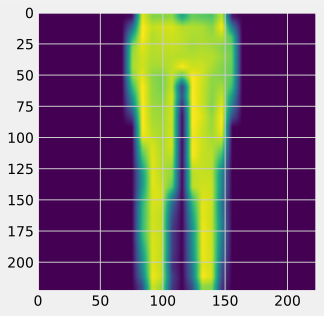

In [25]:
for x, y in data.train_dl:
    print (x.shape, y.shape)
    plt.imshow(x[0].view(224, 224))
    break

In [26]:
x = torch.randn((1, 1, 224, 224))
y = torch.tensor([2])

logits = model(x)
print (logits)
print (model.loss_fn(logits, y))
print (model.accuracy(logits, y))


tensor([[ 0.0009, -0.0048,  0.0029,  0.0004,  0.0136, -0.0032,  0.0059,  0.0002,
         -0.0081,  0.0050]], grad_fn=<AddmmBackward0>)
tensor(2.3010, grad_fn=<NllLossBackward0>)
tensor(0.)


In [27]:
# Test Network
print (x.shape, 'Initial x')

y = x
for layer in model.model:
    y = layer(y)
    print (y.shape, ' after ', layer)

torch.Size([1, 1, 224, 224]) Initial x
torch.Size([1, 96, 54, 54])  after  Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
torch.Size([1, 96, 54, 54])  after  ReLU()
torch.Size([1, 96, 26, 26])  after  MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 256, 26, 26])  after  Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([1, 256, 26, 26])  after  ReLU()
torch.Size([1, 256, 12, 12])  after  MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 384, 12, 12])  after  Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 384, 12, 12])  after  ReLU()
torch.Size([1, 384, 12, 12])  after  Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 384, 12, 12])  after  ReLU()
torch.Size([1, 256, 12, 12])  after  Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 256, 12, 12])  after  ReLU

In [29]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = AlexNet().to(device)
#model = AlexNet()
for batch in data.train_dl:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logits = model(x)
    
    train_loss = model.loss_fn(logits, y)

    print (f'Training loss: {train_loss.item():.4f}')

    model.optimizer.zero_grad(set_to_none=True)
    train_loss.backward()
    model.optimizer.step()



Using mps device
Training loss: 2.3018
Training loss: 2.2985
Training loss: 2.3003
Training loss: 2.2868
Training loss: 2.3019
Training loss: 2.2864
Training loss: 2.2969
Training loss: 2.2747
Training loss: 2.2213
Training loss: 2.2634
Training loss: 2.1930
Training loss: 2.2241
Training loss: 2.0065
Training loss: 1.9488
Training loss: 1.8484
Training loss: 1.6857
Training loss: 1.6510
Training loss: 1.5487
Training loss: 1.7703
Training loss: 1.3424
Training loss: 1.6957
Training loss: 1.4832
Training loss: 1.3920
Training loss: 1.4185
Training loss: 1.3286
Training loss: 1.4912
Training loss: 1.3640
Training loss: 1.3032
Training loss: 1.3029
Training loss: 1.3564
Training loss: 1.2033
Training loss: 1.2835
Training loss: 1.1832
Training loss: 1.4503
Training loss: 1.1713
Training loss: 1.2443
Training loss: 1.3145
Training loss: 1.3460
Training loss: 1.1550
Training loss: 1.1437
Training loss: 1.2551
Training loss: 1.1124
Training loss: 1.1709
Training loss: 1.1752
Training loss: 

KeyboardInterrupt: 

In [ ]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 1024


class Classifier3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(10))

        self.batch_size = 1024
        self.learning_rate = 0.0004
        #self.train_acc = torchmetrics.Accuracy(
        #    task='multiclass', num_classes=10)
        self.model(next(iter(data.train_dl))[0])
        self.apply(self.init_cnn)

    def init_cnn(self, module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            # nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        #self.train_acc(logits, y)
        self.log("train_loss", loss, prog_bar=False,
                 on_step=False, on_epoch=True)
        #self.log('train_acc', self.train_acc, prog_bar=True,
        #         on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        # self.log('train_loss', loss)
        self.log("val_loss", loss, prog_bar=True,
                 on_step=False, on_epoch=True)

        return loss

    def predict_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # x, y = batch
        x = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, patience=10)
        #lr_scheduler = {"scheduler": scheduler,
        #                "interval": "epoch", "monitor": "val_loss"}
        return optimizer #[optimizer], [lr_scheduler]

    def init_cnn(self,module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)


model = Classifier3()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 82 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_be047c4d-b012-47b0-af88-eb8ade72a200.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_be047c4d-b012-47b0-af88-eb8ade72a200.ckpt


0.0004365158322401656


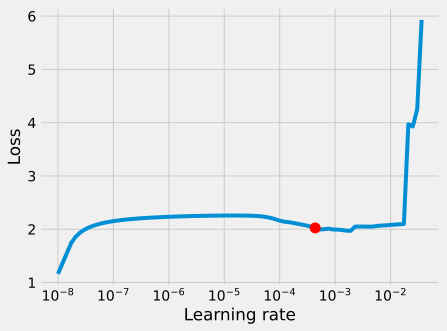

In [ ]:
# run learning rate finder, results override hparams.learning_rate
trainer = pl.Trainer(auto_lr_find=True)

# call tune to find the lr
#lr_finder = trainer.tune(makemore, train_dataloaders=data)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=data.train_dl)

# Results can be found in
#print(lr_finder.results)
print (lr_finder.suggestion())

fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
#lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=10, accelerator="mps", callbacks=[TQDMProgressBar()])
trainer.fit(model=model, train_dataloaders=data.train_dl, val_dataloaders=data.val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 46.8 M
-------------------------------------
46.8 M    Trainable params
0         Non-trainable params
46.8 M    Total params
187.059   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [5]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [7]:
class VGG(MyModule):
    def __init__(self, arch, lr=0.0001, num_classes=10):
        super().__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.model = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.model.apply(self.init_cnn)
        self.configure_optimizers()


torch.Size([64, 1, 224, 224]) torch.Size([64])


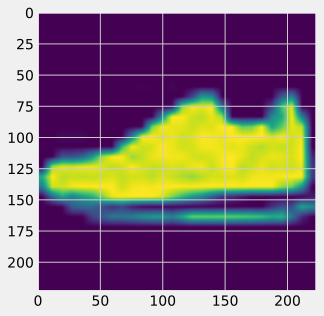

In [9]:
for x, y in data.train_dl:
    print (x.shape, y.shape)
    plt.imshow(x[0].view(224, 224))
    break

In [10]:
lr = torch.logspace(-5,-3,100)
lr

tensor([1.0000e-05, 1.0476e-05, 1.0975e-05, 1.1498e-05, 1.2045e-05, 1.2619e-05,
        1.3219e-05, 1.3849e-05, 1.4508e-05, 1.5199e-05, 1.5923e-05, 1.6681e-05,
        1.7475e-05, 1.8307e-05, 1.9179e-05, 2.0092e-05, 2.1049e-05, 2.2051e-05,
        2.3101e-05, 2.4201e-05, 2.5354e-05, 2.6561e-05, 2.7826e-05, 2.9151e-05,
        3.0539e-05, 3.1993e-05, 3.3516e-05, 3.5112e-05, 3.6784e-05, 3.8535e-05,
        4.0370e-05, 4.2292e-05, 4.4306e-05, 4.6416e-05, 4.8626e-05, 5.0941e-05,
        5.3367e-05, 5.5908e-05, 5.8570e-05, 6.1359e-05, 6.4281e-05, 6.7342e-05,
        7.0548e-05, 7.3907e-05, 7.7426e-05, 8.1113e-05, 8.4975e-05, 8.9022e-05,
        9.3260e-05, 9.7701e-05, 1.0235e-04, 1.0723e-04, 1.1233e-04, 1.1768e-04,
        1.2328e-04, 1.2915e-04, 1.3530e-04, 1.4175e-04, 1.4850e-04, 1.5557e-04,
        1.6298e-04, 1.7074e-04, 1.7886e-04, 1.8738e-04, 1.9630e-04, 2.0565e-04,
        2.1544e-04, 2.2570e-04, 2.3645e-04, 2.4771e-04, 2.5950e-04, 2.7186e-04,
        2.8480e-04, 2.9836e-04, 3.1257e-

In [13]:
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
#print(f"Using {device} device")
#model = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).to(device)
#model = AlexNet()
#losses = []
model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-5)
for step, batch in enumerate(data.train_dl):

    x, y = batch
    x, y = x.to(device), y.to(device)
    logits = model(x)
    
    train_loss = model.loss_fn(logits, y)
    losses.append(train_loss)

    if step % 50 == 0:
        mlosses = torch.tensor(losses)
        print (f'Step {step}, Training loss: {mlosses[-50:].mean().item():.4f}')

    model.optimizer.zero_grad(set_to_none=True)
    train_loss.backward()
    model.optimizer.step()

Step 0, Training loss: 0.5284
Step 50, Training loss: 0.4962
Step 100, Training loss: 0.4595
Step 150, Training loss: 0.4739
Step 200, Training loss: 0.4628
Step 250, Training loss: 0.4485
Step 300, Training loss: 0.4361
Step 350, Training loss: 0.4438
Step 400, Training loss: 0.4408
Step 450, Training loss: 0.4429
Step 500, Training loss: 0.4265
Step 550, Training loss: 0.4347
Step 600, Training loss: 0.4138
Step 650, Training loss: 0.3832
Step 700, Training loss: 0.4049
Step 750, Training loss: 0.3952
Step 800, Training loss: 0.3923
Step 850, Training loss: 0.3858
Step 900, Training loss: 0.3860


In [22]:
del (model)
del (x)
del(y)

tensor(2.3329e-05)

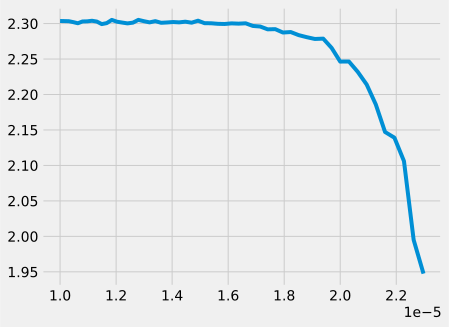

In [19]:
ll = torch.tensor(losses)
plt.plot(lr[:55], ll[:55])
lr[55]

In [16]:
model.eval()
accs = []
for step, batch in enumerate(data.val_dl):

    x, y = batch
    x, y = x.to(device), y.to(device)

    logits = model(x)

    acc = model.accuracy(logits, y)
    accs.append(acc)
    print (step, acc)

0 tensor(0.8125, device='mps:0')
1 tensor(0.8906, device='mps:0')
2 tensor(0.9531, device='mps:0')
3 tensor(0.9219, device='mps:0')
4 tensor(0.8125, device='mps:0')
5 tensor(0.8750, device='mps:0')
6 tensor(0.7969, device='mps:0')
7 tensor(0.9219, device='mps:0')
8 tensor(0.8125, device='mps:0')
9 tensor(0.7969, device='mps:0')
10 tensor(0.8125, device='mps:0')
11 tensor(0.7969, device='mps:0')
12 tensor(0.9062, device='mps:0')
13 tensor(0.8906, device='mps:0')
14 tensor(0.8906, device='mps:0')
15 tensor(0.8906, device='mps:0')
16 tensor(0.9375, device='mps:0')
17 tensor(0.8594, device='mps:0')
18 tensor(0.8125, device='mps:0')
19 tensor(0.8906, device='mps:0')
20 tensor(0.9375, device='mps:0')
21 tensor(0.8281, device='mps:0')
22 tensor(0.8281, device='mps:0')
23 tensor(0.8438, device='mps:0')
24 tensor(0.8281, device='mps:0')
25 tensor(0.8438, device='mps:0')
26 tensor(0.8906, device='mps:0')
27 tensor(0.8281, device='mps:0')
28 tensor(0.8906, device='mps:0')
29 tensor(0.7812, device

KeyboardInterrupt: 

In [17]:
acccs = torch.tensor(accs)

print (acccs.mean().item())

0.8669599294662476


## Google Net (GoogLeNet)

#### WIth Inception layers

In [34]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Resize(size = (96, 96))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 512, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 512, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 118, 20)

In [35]:
class Inception(MyModule):
    # `c1`--`c4` are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet(MyModule):
    def __init__(self, lr=0.1, num_classes=10):
        super(GoogleNet, self).__init__()
        self.model = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(num_classes))
        self.model.apply(self.init_cnn)
        self.configure_optimizers()

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                            Inception(160, (112, 224), (24, 64), 64),
                            Inception(128, (128, 256), (24, 64), 64),
                            Inception(112, (144, 288), (32, 64), 64),
                            Inception(256, (160, 320), (32, 128), 128),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())



In [47]:
lr = torch.logspace(-6,-3,500)
lr

tensor([1.0000e-06, 1.0139e-06, 1.0281e-06, 1.0424e-06, 1.0569e-06, 1.0717e-06,
        1.0866e-06, 1.1018e-06, 1.1171e-06, 1.1327e-06, 1.1485e-06, 1.1645e-06,
        1.1807e-06, 1.1972e-06, 1.2139e-06, 1.2308e-06, 1.2479e-06, 1.2653e-06,
        1.2830e-06, 1.3009e-06, 1.3190e-06, 1.3374e-06, 1.3560e-06, 1.3749e-06,
        1.3941e-06, 1.4135e-06, 1.4332e-06, 1.4532e-06, 1.4735e-06, 1.4940e-06,
        1.5148e-06, 1.5359e-06, 1.5573e-06, 1.5791e-06, 1.6011e-06, 1.6234e-06,
        1.6460e-06, 1.6690e-06, 1.6922e-06, 1.7158e-06, 1.7397e-06, 1.7640e-06,
        1.7886e-06, 1.8135e-06, 1.8388e-06, 1.8644e-06, 1.8904e-06, 1.9167e-06,
        1.9435e-06, 1.9706e-06, 1.9980e-06, 2.0259e-06, 2.0541e-06, 2.0828e-06,
        2.1118e-06, 2.1412e-06, 2.1711e-06, 2.2013e-06, 2.2320e-06, 2.2631e-06,
        2.2947e-06, 2.3267e-06, 2.3591e-06, 2.3920e-06, 2.4253e-06, 2.4591e-06,
        2.4934e-06, 2.5282e-06, 2.5634e-06, 2.5991e-06, 2.6354e-06, 2.6721e-06,
        2.7094e-06, 2.7471e-06, 2.7854e-

In [72]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = GoogleNet().to(device)

losses = []

i = 0
model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-4)
for epoch in range(5):
    for step, batch in enumerate(data.train_dl):

        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        
        train_loss = model.loss_fn(logits, y)
        losses.append(train_loss)
    
        if step % 25 == 0:
            mlosses = torch.tensor(losses)
            print (f'Step {step}, Training loss: {mlosses[-25:].mean().item():.4f}')

        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()
        i += 1

Using mps device
Step 0, Training loss: 2.3012
Step 25, Training loss: 2.3030
Step 50, Training loss: 2.3027
Step 75, Training loss: 2.3028
Step 100, Training loss: 2.2645
Step 0, Training loss: 1.8619
Step 25, Training loss: 1.3519
Step 50, Training loss: 1.1141
Step 75, Training loss: 1.0210
Step 100, Training loss: 0.9709
Step 0, Training loss: 0.9606
Step 25, Training loss: 0.9112
Step 50, Training loss: 0.9266
Step 75, Training loss: 0.8702
Step 100, Training loss: 0.8406
Step 0, Training loss: 0.9287
Step 25, Training loss: 0.7668
Step 50, Training loss: 0.7152
Step 75, Training loss: 0.7329
Step 100, Training loss: 0.7128
Step 0, Training loss: 0.6875
Step 25, Training loss: 0.6880
Step 50, Training loss: 0.6748
Step 75, Training loss: 0.6450
Step 100, Training loss: 0.6327


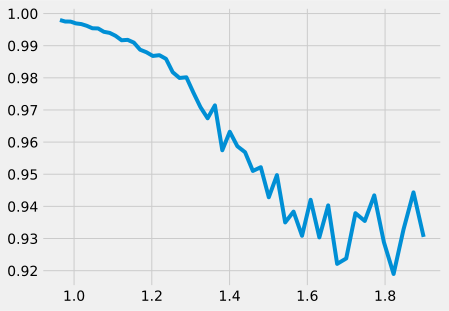

In [70]:
ll = torch.tensor(losses)
plt.plot(lr[330:380]/1e-4, ll[330:380]/ll[:400].max())
#xx = ll[:400]
#yy = lr[:400]

#gg = (-(xx[1:] - xx[:-1]))#/(yy[1:] - yy[:-1])

#plt.semilogx(yy[:-1], gg/gg.max())


In [38]:
len(data.train_dl)

118

In [24]:
for batch in data.train_dl:
    x, y = batch
    break

In [25]:
model = GoogleNet()

print (x.shape)
y = model(x)
print (y.shape)

torch.Size([64, 1, 96, 96])
torch.Size([64, 10])


In [78]:
model = GoogleNet()
print (model)

GoogleNet(
  (model): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
        (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
        (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (b4_1): MaxPool2d(kernel_size=3,

In [80]:
print (model.model[2])

Sequential(
  (0): Inception(
    (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
    (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
    (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (b4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (b4_2): LazyConv2d(0, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Inception(
    (b1_1): LazyConv2d(0, 128, kernel_size=(1, 1), stride=(1, 1))
    (b2_1): LazyConv2d(0, 128, kernel_size=(1, 1), stride=(1, 1))
    (b2_2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b3_1): LazyConv2d(0, 32, kernel_size=(1, 1), stride=(1, 1))
    (b3_2): LazyConv2d(0, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (b4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mod

In [81]:
y = x

print ('\nOriginal x')
print (y.shape, f'{y.numel()/1.0e6:.2f}M params from  original x')

# First block
print ('\nFirst block')
for layer in model.model[0]:
    y = layer(y)
    print (y.shape, f'{y.numel()/1.0e6:.2f}M params from ', layer)

# Second block
print ('\nSecond block')
for layer in model.model[1]:
    y = layer(y)
    print (y.shape, f'{y.numel()/1.0e6:.2f}M params from ', layer)


# First Inception 
print ('\nThird block, First Inception Layer')
y1 = model.model[2][0].b1_1(y)
print (y1.shape, f'{y1.numel()/1.0e6:.2f}M params from ', model.model[2][0].b1_1)
y2= model.model[2][0].b2_1(y)
print (y2.shape, f'{y2.numel()/1.0e6:.2f}M params from ', model.model[2][0].b2_1)
y2= model.model[2][0].b2_2(y2)
print (y2.shape, f'{y2.numel()/1.0e6:.2f}M params from ', model.model[2][0].b2_2)
y3= model.model[2][0].b3_1(y)
print (y3.shape, f'{y3.numel()/1.0e6:.2f}M params from ', model.model[2][0].b3_1)
y3= model.model[2][0].b3_2(y3)
print (y3.shape, f'{y3.numel()/1.0e6:.2f}M params from ', model.model[2][0].b3_2)
y4= model.model[2][0].b4_1(y)
print (y4.shape, f'{y4.numel()/1.0e6:.2f}M params from ', model.model[2][0].b4_1)
y4= model.model[2][0].b4_2(y3)
print (y4.shape, f'{y4.numel()/1.0e6:.2f}M params from ', model.model[2][0].b4_2)
y = torch.cat((y1, y2, y3, y4), dim=1)
print (y.shape, f'{y.numel()/1.0e6:.2f}M params from torch.cat((y1, y2, y3, y4), dim=1)')






Original x
torch.Size([64, 1, 96, 96]) 0.59M params from  original x

First block
torch.Size([64, 64, 48, 48]) 9.44M params from  Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
torch.Size([64, 64, 48, 48]) 9.44M params from  ReLU()
torch.Size([64, 64, 24, 24]) 2.36M params from  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Second block
torch.Size([64, 64, 24, 24]) 2.36M params from  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
torch.Size([64, 64, 24, 24]) 2.36M params from  ReLU()
torch.Size([64, 192, 24, 24]) 7.08M params from  Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 192, 24, 24]) 7.08M params from  ReLU()
torch.Size([64, 192, 12, 12]) 1.77M params from  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Third block, First Inception Layer
torch.Size([64, 64, 12, 12]) 0.59M params from  Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
torch.Size([64, 96, 12, 12])

In [82]:
logits = model(x)

RuntimeError: Given groups=1, weight of size [32, 32, 1, 1], expected input[64, 192, 12, 12] to have 32 channels, but got 192 channels instead

## Batch Norm

#### And Layer Norm

In [85]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Resize(size = (224, 224))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=ToTensor())
        self.val = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 64, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 938, 10)

In [86]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean)/torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)

        X_hat = (X - mean)/torch.sqrt(var + eps)
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * mean

    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


In [87]:
class BatchNorm(MyModule):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)

        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1.0e-5, momentum=0.1)
        return Y


In [88]:
class BNLeNetScratch(MyModule):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.ReLU(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
        self.configure_optimizers()
        #self.apply(self.init_cnn)

    def init(self, x):
        _ = self(x)
        self.apply(self.init_cnn)


In [89]:
device = "cpu"
model = BNLeNetScratch().to(device)
max_epochs = 10


for batch in data.train_dl:
    x, y = batch
    x, y = x.to(device), y.to(device)
    break

with torch.no_grad():
    model.init(x)


lr = torch.logspace(-6, -1, 500)

model.optimizer = torch.optim.AdamW(model.parameters(), lr=2.0e-4)
for epoch in range(max_epochs):
    train_losses = []
    for step, batch in enumerate(data.train_dl):

        # if step == 500:
        #    break

        x, y = batch
        x, y = x.to(device), y.to(device)

        train_logits = model(x)

        train_loss = model.loss_fn(train_logits, y)
        train_losses.append(train_loss.item())

        # model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        # if step % 100 == 0:
        #    mtrain_loss = torch.tensor(train_losses)[-50:].mean().item()
        #    print (f'step {step:>3d} with loss {mtrain_loss:.4f}')

    #with torch.no_grad():
    for batch in data.val_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        break

    #with torch.no_grad():
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()

    mtrain_loss = torch.tensor(train_losses).mean().item()
    print(f'epoch {epoch:>3d}/{max_epochs:>3d} with train loss {mtrain_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')
    


epoch   0/ 10 with train loss 0.7151, train loss 0.4871, and accuracy 0.8184
epoch   1/ 10 with train loss 0.4407, train loss 0.4018, and accuracy 0.8555
epoch   2/ 10 with train loss 0.3815, train loss 0.3993, and accuracy 0.8486
epoch   3/ 10 with train loss 0.3471, train loss 0.3778, and accuracy 0.8691
epoch   4/ 10 with train loss 0.3236, train loss 0.3524, and accuracy 0.8799
epoch   5/ 10 with train loss 0.3059, train loss 0.3457, and accuracy 0.8828
epoch   6/ 10 with train loss 0.2909, train loss 0.3280, and accuracy 0.8916
epoch   7/ 10 with train loss 0.2791, train loss 0.3000, and accuracy 0.8838
epoch   8/ 10 with train loss 0.2679, train loss 0.3219, and accuracy 0.8867
epoch   9/ 10 with train loss 0.2579, train loss 0.2980, and accuracy 0.8848


In [92]:
class BNLeNet(MyModule):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

    def init(self, x):
        logits = self(x)
        self.apply(self.init_cnn)
        return logits


In [102]:
device = "cpu"
model = BNLeNet().to(device)
max_epochs = 10


# Initial step
for batch in data.train_dl:
    x, y = batch
    x, y = x.to(device), y.to(device)
    break

init_logits = model.init(x)
mtrain_loss = model.loss_fn(init_logits, y).item()
val_loss = mtrain_loss
val_acc = model.accuracy(init_logits, y)
epoch = 0
print(f'epoch {epoch:>3d}/{max_epochs:>3d} with train loss {mtrain_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


lr = torch.logspace(-6, -1, 500)

model.optimizer = torch.optim.AdamW(model.parameters(), lr=3.0e-4)
for epoch in range(1, max_epochs+1):
    train_losses = []
    for step, batch in enumerate(data.train_dl):

        #if step == 500:
        #    break

        x, y = batch
        x, y = x.to(device), y.to(device)

        train_logits = model(x)

        train_loss = model.loss_fn(train_logits, y)
        train_losses.append(train_loss.item())

        #model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        
        # if step % 100 == 0:
        #    mtrain_loss = torch.tensor(train_losses)[-50:].mean().item()
        #    print (f'step {step:>3d} with loss {mtrain_loss:.4f}')

    #break
    #with torch.no_grad():
    for batch in data.val_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        break

    #with torch.no_grad():
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()

    mtrain_loss = torch.tensor(train_losses).mean().item()
    print(f'epoch {epoch:>3d}/{max_epochs:>3d} with train loss {mtrain_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')



epoch   0/ 10 with train loss 2.3775, val loss 2.3775, and accuracy 0.1250
epoch   1/ 10 with train loss 0.9219, val loss 0.6594, and accuracy 0.7871
epoch   2/ 10 with train loss 0.5466, val loss 0.5362, and accuracy 0.8135
epoch   3/ 10 with train loss 0.4582, val loss 0.4585, and accuracy 0.8418
epoch   4/ 10 with train loss 0.4165, val loss 0.4630, and accuracy 0.8340
epoch   5/ 10 with train loss 0.3935, val loss 0.3735, and accuracy 0.8594
epoch   6/ 10 with train loss 0.3709, val loss 0.4129, and accuracy 0.8545
epoch   7/ 10 with train loss 0.3570, val loss 0.3833, and accuracy 0.8682
epoch   8/ 10 with train loss 0.3439, val loss 0.3687, and accuracy 0.8604
epoch   9/ 10 with train loss 0.3331, val loss 0.3411, and accuracy 0.8691
epoch  10/ 10 with train loss 0.3244, val loss 0.3465, and accuracy 0.8672


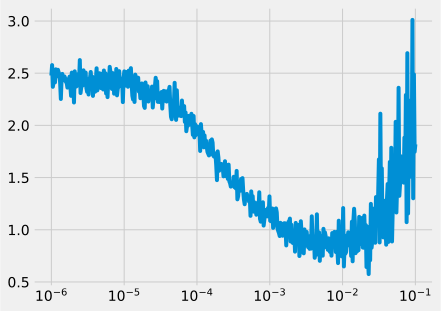

In [100]:
plt.semilogx(lr, train_losses)

In [15]:
del(model)

torch.Size([120, 256])
tensor(0.0884)


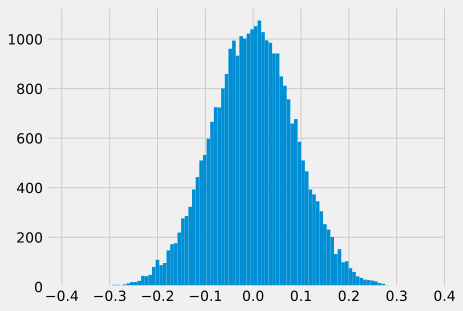

In [13]:
model = BNLeNetScratch()
for batch in data.train_dl:
    x, y = batch

with torch.no_grad():
    model.init(x)

print (model.state_dict()['model.9.weight'].shape)
print (model.state_dict()['model.9.weight'].std())

plt.hist(model.state_dict()['model.9.weight'].flatten(),100);

## ResNet

In [3]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        transforms = Compose([ToTensor(), Resize(size = (96, 96))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 128, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 128, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 469, 79)

In [4]:

class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [5]:
class ResNet(MyModule):

    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.model = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.model.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.model.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

In [6]:
device = "cpu"
model = ResNet(((2, 64), (2, 128), (2, 256), (2, 512))).to(device)
max_epochs = 10


# Initial step
for batch in data.train_dl:
    x, y = batch
    x, y = x.to(device), y.to(device)
    break

init_logits = model.init(x)
mtrain_loss = model.loss_fn(init_logits, y).item()
val_loss = mtrain_loss
val_acc = model.accuracy(init_logits, y)
epoch = 0
print(f'epoch {epoch:>3d}/{max_epochs:>3d} with train loss {mtrain_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')



lr = torch.logspace(-6, -1, 500)

model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-5)
for epoch in range(1, max_epochs+1):
    train_losses = []
    for step, batch in enumerate(data.train_dl):

        if step == 500:
            break

        x, y = batch
        x, y = x.to(device), y.to(device)

        train_logits = model(x)

        train_loss = model.loss_fn(train_logits, y)
        train_losses.append(train_loss.item())

        model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        
        if step % 50 == 0:
            mtrain_loss = torch.tensor(train_losses)[-50:].mean().item()
            print (f'step {step:>3d} with loss {mtrain_loss:.4f}')

    break
    #with torch.no_grad():
    for batch in data.val_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        break

    #with torch.no_grad():
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()

    mtrain_loss = torch.tensor(train_losses).mean().item()
    print(f'epoch {epoch:>3d}/{max_epochs:>3d} with train loss {mtrain_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')




epoch   0/ 10 with train loss 2.4354, val loss 2.4354, and accuracy 0.0859
step   0 with loss 5.8961


KeyboardInterrupt: 

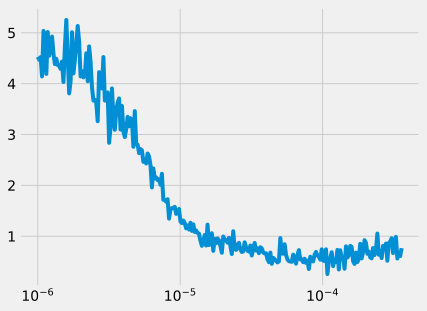

In [131]:
plt.semilogx(lr[:256], train_losses[:256])